In [1]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

from histaug.data import Kather100k
from histaug.augmentations import load_augmentations

In [20]:
torch.manual_seed(42)

augmentations = load_augmentations()

ds = Kather100k("/data/NCT-CRC-HE-100K")
loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0, collate_fn=lambda x: x[0])

# Get an example patch for each class
examples = {}
it = iter(loader)
while not all(c in examples for c in ds.classes):
    img, label, *_ = next(it)
    if ds.classes[label] not in examples:
        examples[ds.classes[label]] = img

2023-09-10 14:27:45.854 | INFO     | histaug.augmentations:__init__:30 - Fitting Macenko normalizer to /app/normalization_template.jpg


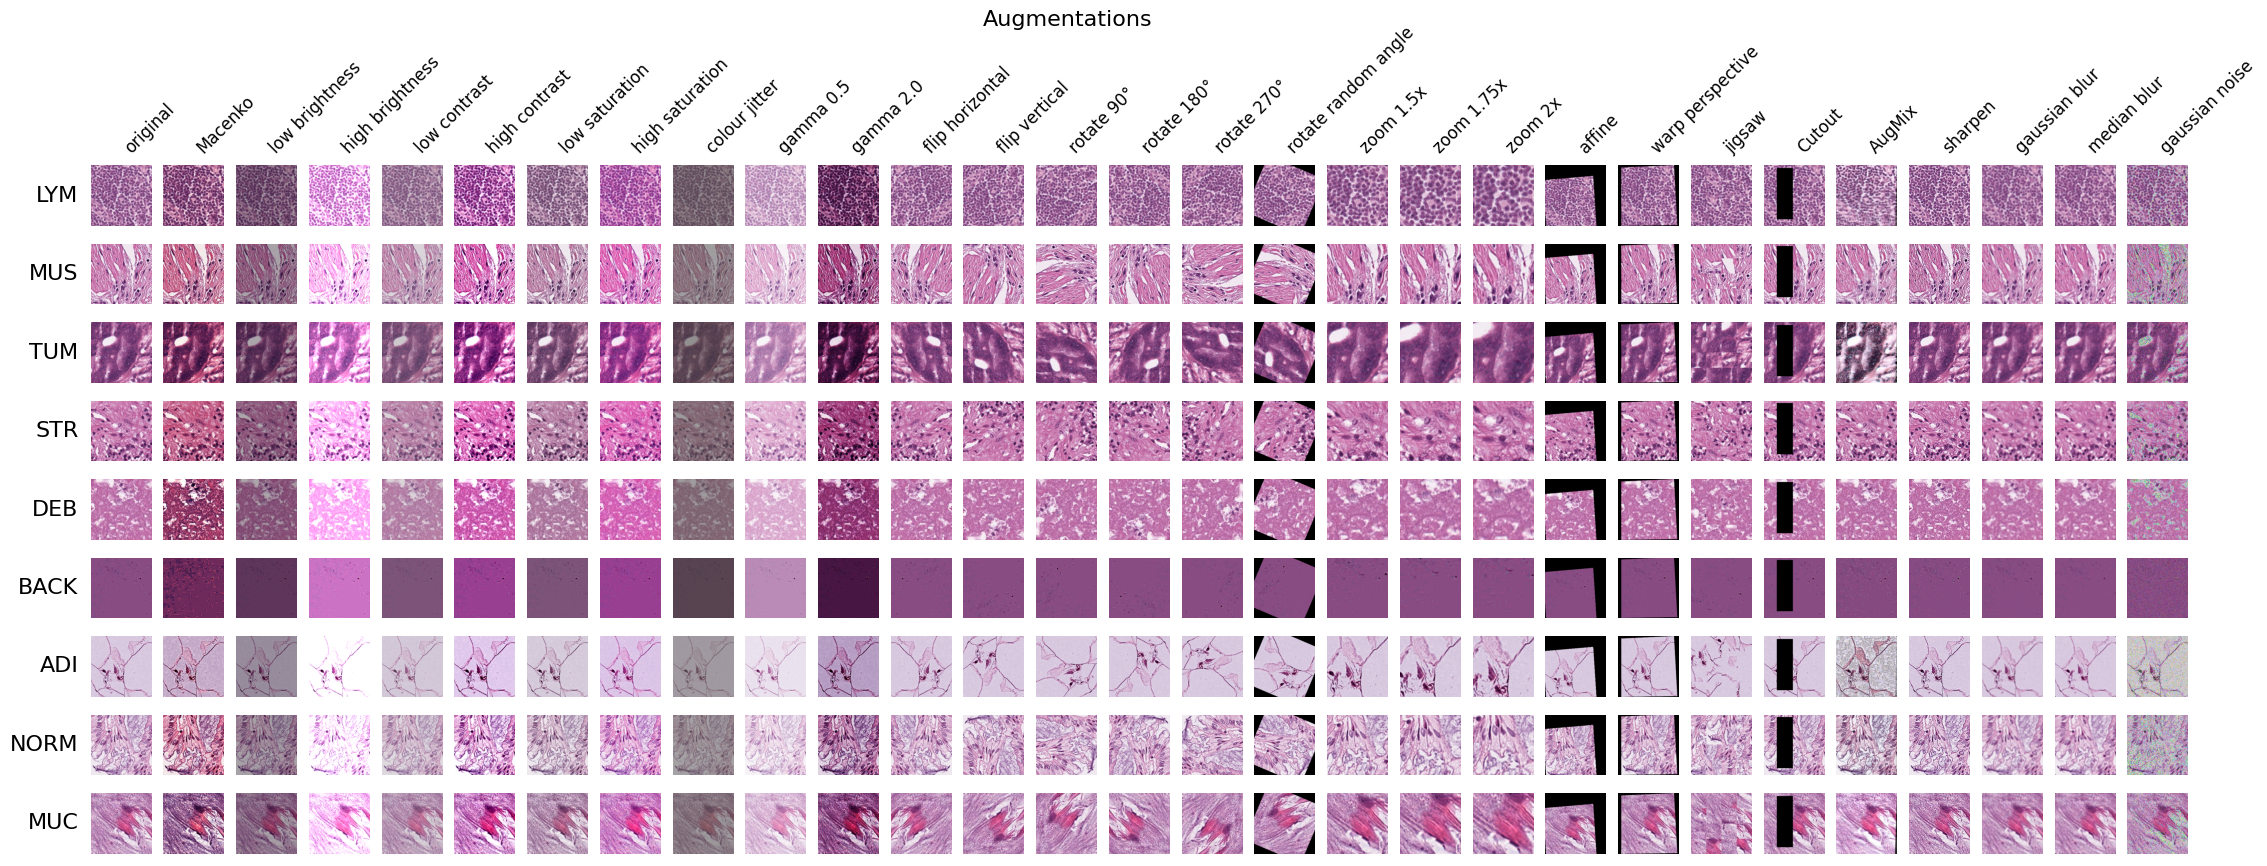

In [27]:
def visualize_augmentations(imgs, labels, augmentations, image_fn, device="cuda"):
    imgs = imgs.to(device)
    augmentations.to(device)

    with torch.no_grad():
        aug_imgs = {aug_name: aug(imgs) for aug_name, aug in augmentations.items()}

    n_imgs = len(imgs)
    n_augs = len(augmentations)

    fig, axs = plt.subplots(n_imgs, n_augs + 2, figsize=(n_augs, n_imgs))

    title_kwargs = dict(rotation=45, ha="left", va="bottom")

    for i, (ax_row, img, label) in enumerate(zip(axs, imgs, labels)):
        ax_label, ax_orig, *ax_augs = ax_row

        ax_label.text(1.0, 0.5, label, transform=ax_label.transAxes, fontsize=16, ha="right", va="center")
        ax_label.axis("off")

        ax_orig.imshow(image_fn(img))
        ax_orig.axis("off")
        if i == 0:
            ax_orig.set_title("original", **title_kwargs)

        for ax_aug, (aug_name, augs) in zip(ax_augs, aug_imgs.items()):
            ax_aug.imshow(image_fn(augs[i]))
            ax_aug.axis("off")
            if i == 0:
                ax_aug.set_title(aug_name, **title_kwargs)

    fig.suptitle("Augmentations", fontsize=16, y=1.05)

    return fig


fig = visualize_augmentations(
    torch.stack(list(examples.values())), examples.keys(), augmentations, image_fn=ds.inverse_transform, device="cuda"
)